In [1]:


import cv2
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from insightface.app import FaceAnalysis
from torch.nn import CosineSimilarity


import wandb
import matplotlib.pyplot as plt

app = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])
app.prepare(ctx_id=-1, det_size=(640, 640))

def get_embedding(img_path):
    img_bgr = cv2.imread(img_path)
    faces = app.get(img_bgr)
    if len(faces) == 0:
        raise RuntimeError(f"Kein Gesicht in {img_path}")
    emb_np = faces[0].normed_embedding
    return torch.from_numpy(emb_np).float()

emb_A_front = get_embedding("../data/moritz_without_brett/input/mid_right.jpg")
emb_A_side  = get_embedding("../data/moritz_without_brett/input/mid_left.jpg")
emb_B_front = get_embedding("../outputs/moritz_without_brett_model/test/ours_5950/renders/00000.png")
emb_C_front = get_embedding("../data/can_with_brett/input/front.jpg")

cos = CosineSimilarity(dim=0)
sim_AA = cos(emb_A_front, emb_A_side).item()
sim_AB = cos(emb_A_front, emb_B_front).item()
sim_AC = cos(emb_A_front, emb_C_front).item()
sim_AC_side = cos(emb_A_side, emb_C_front).item()

print(f"Ähnlichkeit A_front vs A_side: {sim_AA:.4f}")
print(f"Ähnlichkeit A_front vs B_front: {sim_AB:.4f}")
print(f"Ähnlichkeit A_front vs C_front: {sim_AC:.4f}")
print(f"Ähnlichkeit A_side vs C_front: {sim_AC_side:.4f}")


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\can-e/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\can-e/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\can-e/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\can-e/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\can-e/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

C:\Users\can-e\PycharmProjects\p5_gaussian_splatting\.venv\Lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


Ähnlichkeit A_front vs A_side: 0.8390
Ähnlichkeit A_front vs B_front: 0.5876
Ähnlichkeit A_front vs C_front: -0.0337
Ähnlichkeit A_side vs C_front: 0.0494


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\can-e/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\can-e/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\can-e/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\can-e/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\can-e/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

C:\Users\can-e\PycharmProjects\p5_gaussian_splatting\.venv\Lib\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


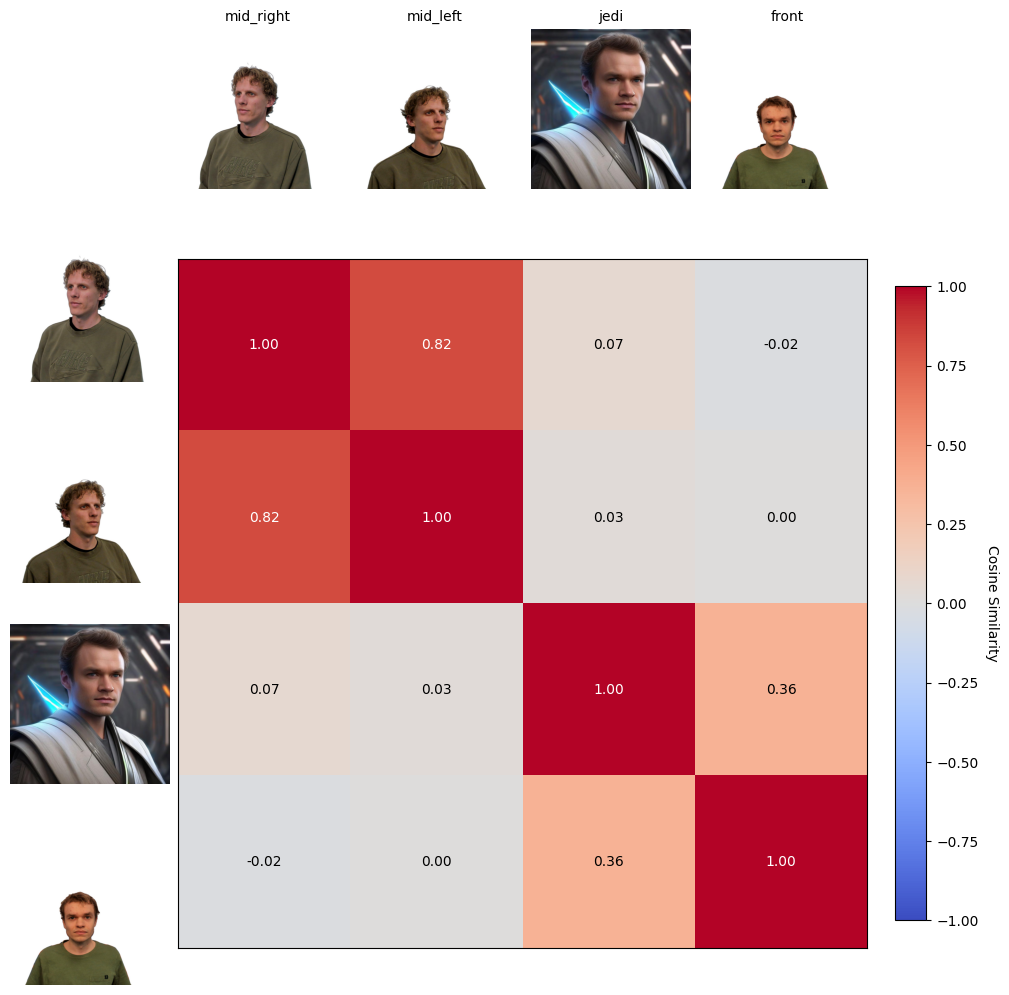

In [2]:


def plot_face_similarity_matrix(
    image_paths,
    labels=None,
    model_name='buffalo_l',
    det_size=(640, 640),
    cell_size=2
):

    app = FaceAnalysis(name=model_name, providers=['CPUExecutionProvider'])
    app.prepare(ctx_id=-1, det_size=det_size)
    
    if labels is None:
        labels = [Path(p).stem for p in image_paths]
    
    embs = []
    for p in image_paths:
        img = cv2.imread(p)
        if img is None:
            raise FileNotFoundError(f"Bild nicht gefunden: {p}")
        faces = app.get(img)
        if not faces:
            raise RuntimeError(f"Kein Gesicht in {p}")
        embs.append(faces[0].normed_embedding.astype(np.float32))
    
    n = len(embs)
    sim = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            sim[i, j] = float(np.dot(embs[i], embs[j]))
    
    fig = plt.figure(
        figsize=(cell_size*(n+1), cell_size*(n+1)),
        constrained_layout=True
    )
    gs = fig.add_gridspec(
        n+1, n+1,
        width_ratios=[1] + [1]*n,
        height_ratios=[1] + [1]*n
    )
    
    ax_heat = fig.add_subplot(gs[1:, 1:])
    im = ax_heat.imshow(sim, cmap='coolwarm', vmin=-1, vmax=1)
    ax_heat.set_xticks([])
    ax_heat.set_yticks([])
    ax_heat.set_aspect('equal')
    
    for i in range(n):
        for j in range(n):
            col = 'white' if abs(sim[i, j]) > 0.5 else 'black'
            ax_heat.text(j, i, f"{sim[i, j]:.2f}",
                         ha='center', va='center', color=col)
    
    cbar = fig.colorbar(im, ax=ax_heat, fraction=0.046, pad=0.04)
    cbar.set_label('Cosine Similarity', rotation=270, labelpad=15)
    
    for j, p in enumerate(image_paths):
        ax = fig.add_subplot(gs[0, j+1])
        img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(labels[j], fontsize=10)
        ax.set_aspect('equal')
    
    for i, p in enumerate(image_paths):
        ax = fig.add_subplot(gs[i+1, 0])
        img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
        ax.set_aspect('equal')

    
    plt.show()




plot_face_similarity_matrix(["../data/jan_without_brett/input/mid_right.jpg",
                             "../data/jan_without_brett/input/mid_left.jpg",
                             "../diffusion_images/Can_Images_P5/1/jedi.png",
                             "../data/can_with_brett/input/front.jpg"
                             ])



In [12]:


app = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])
app.prepare(ctx_id=-1, det_size=(640, 640))
cos = CosineSimilarity(dim=0)

IMAGE_EXTS = [".png", ".jpg", ".jpeg"]

def find_image(path_stem: Path) -> Path:
    for ext in IMAGE_EXTS:
        p = path_stem.with_suffix(ext)
        if p.is_file():
            return p
    raise FileNotFoundError(f"Kein Bild gefunden für {path_stem} (gesucht: {IMAGE_EXTS})")

def get_embedding(img_path: Path) -> torch.Tensor:
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        raise RuntimeError(f"cv2.imread konnte {img_path} nicht laden")
    faces = app.get(img_bgr)
    if len(faces) == 0:
        raise RuntimeError(f"Kein Gesicht gefunden in {img_path}")
    emb_np = faces[0].normed_embedding
    return torch.from_numpy(emb_np).float()

base_dir = Path("diffusion_images")
persons = [d for d in base_dir.iterdir() 
           if d.is_dir() and d.name.endswith("_Images_P5")]

results = []

for person_dir in persons:
    person_name = person_dir.name.replace("_Images_P5", "")
    
    originals = {}
    for side in ["left", "mid_left", "front", "mid_right", "right"]:
        stem = person_dir / side
        img_file = find_image(stem)
        originals[side] = get_embedding(img_file)
    
    for folder in ["1", "2", "3"]:
        folder_path = person_dir / folder
        if not folder_path.is_dir():
            print(f"Warnung: {folder_path} nicht gefunden, übersprungen")
            continue
        
        for img_file in folder_path.iterdir():
            if img_file.suffix.lower() not in IMAGE_EXTS:
                continue
            prompt = img_file.stem
            
            emb = get_embedding(img_file)
            sims = [cos(emb, orig).item() for orig in originals.values()]
            mean_sim = float(np.mean(sims))
            std_sim  = float(np.std(sims))
            min_sim  = float(np.min(sims))
            max_sim  = float(np.max(sims))
            
            results.append({
                "person": person_name,
                "folder": folder,
                "prompt": prompt,
                "mean_similarity": mean_sim,
                "std_similarity": std_sim,
                "min_similarity": min_sim,
                "max_similarity": max_sim
            })

df = pd.DataFrame(results)
csv_path = base_dir / "similarity_results.csv"
df.to_csv(csv_path, index=False)
print(f"Ergebnis geschrieben: {csv_path}")


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\can-e/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\can-e/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\can-e/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\can-e/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\can-e/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

In [13]:
df_similarity = pd.read_csv("../"+csv_path)

df_similarity

,person,folder,prompt,mean_similarity,std_similarity,min_similarity,max_similarity
0,Can,1,angel,0.420211,0.037782,0.362585,0.463809
1,Can,1,hero,0.455940,0.018479,0.430455,0.480863
2,Can,1,jedi,0.315775,0.025385,0.285187,0.357526
3,Can,1,normal,0.582122,0.011798,0.571180,0.604480
4,Can,2,angel,0.320062,0.013881,0.303416,0.335098
...,...,...,...,...,...,...,...
79,Susanne,2,normal,0.501603,0.024317,0.459572,0.525336
80,Susanne,3,angel,0.240030,0.062887,0.140182,0.323748
81,Susanne,3,hero,0.270967,0.042787,0.220807,0.340149
82,Susanne,3,jedi,0.264217,0.034518,0.196322,0.288045


<Axes: title={'center': 'Durchschnittliche Ähnlichkeit pro Ordner'}, xlabel='folder'>

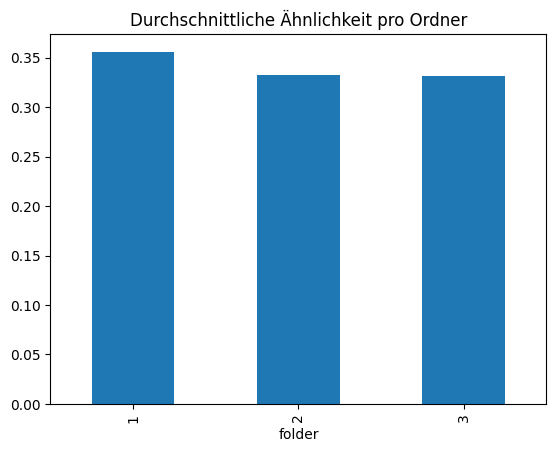

In [14]:
#mean mean sim for evey folder
mean_sims = df_similarity.groupby("folder")["mean_similarity"].mean()
mean_sims = mean_sims.sort_index()
mean_sims.plot(kind='bar', title='Durchschnittliche Ähnlichkeit pro Ordner')

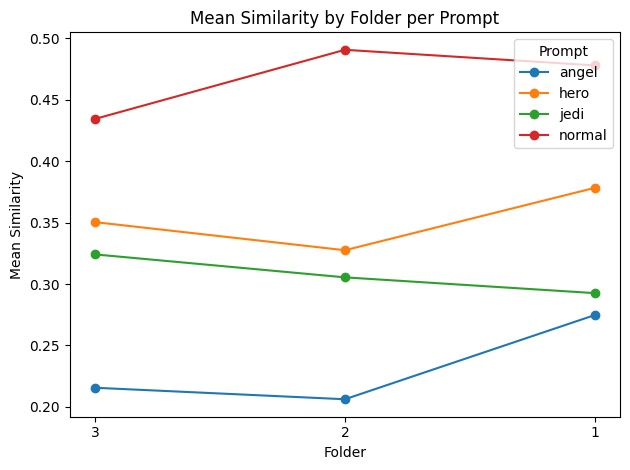

In [15]:



df_similarity['folder'] = df_similarity['folder'].astype(int)

grouped = (
    df_similarity
    .groupby(['prompt', 'folder'])['mean_similarity']
    .mean()
    .reset_index()
)

plt.figure()
for prompt in grouped['prompt'].unique():
    data = grouped[grouped['prompt'] == prompt].sort_values('folder', ascending=False)
    plt.plot(
        data['folder'],
        data['mean_similarity'],
        marker='o',
        label=prompt
    )

plt.xlabel('Folder')
plt.ylabel('Mean Similarity')
plt.title('Mean Similarity by Folder per Prompt')
plt.xticks([3, 2, 1])
plt.gca().invert_xaxis()
plt.legend(title='Prompt')
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Durchschnittliche Ähnlichkeit pro Prompt'}, xlabel='prompt'>

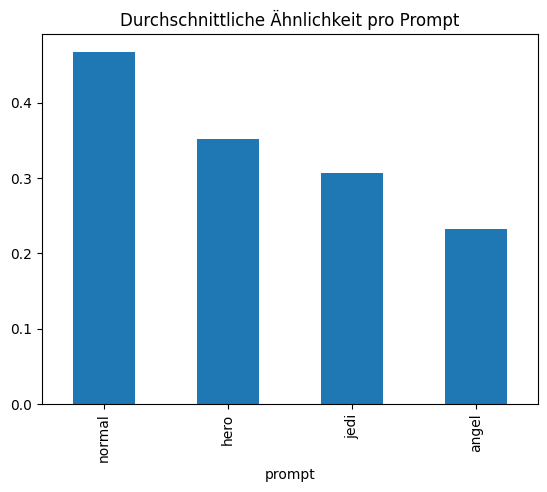

In [33]:
#plot mean sim of every prompt
mean_sims = df_similarity.groupby("prompt")["mean_similarity"].mean()
mean_sims = mean_sims.sort_values(ascending=False)
mean_sims.plot(kind='bar', title='Durchschnittliche Ähnlichkeit pro Prompt')


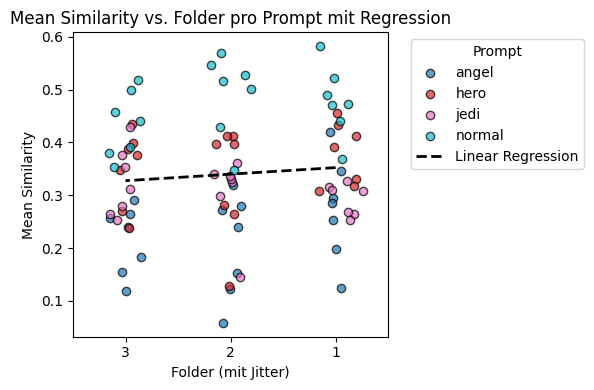

In [39]:
df_similarity['folder'] = df_similarity['folder'].astype(int)

np.random.seed(42)
jitter_strength = 0.1
df_similarity['folder_jitter'] = df_similarity['folder'] + np.random.normal(0, jitter_strength, size=len(df_similarity))

fig, ax = plt.subplots(figsize=(6, 4))
prompts = df_similarity['prompt'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(prompts)))
color_map = dict(zip(prompts, colors))

for prompt in prompts:
    subset = df_similarity[df_similarity['prompt'] == prompt]
    ax.scatter(
        subset['folder_jitter'],
        subset['mean_similarity'],
        label=prompt,
        color=color_map[prompt],
        alpha=0.7,
        edgecolor='k'
    )

x = df_similarity['folder'].values
y = df_similarity['mean_similarity'].values
slope, intercept = np.polyfit(x, y, 1)
x_line = np.array([1, 2, 3])
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, color='black', linestyle='--', linewidth=2, label='Linear Regression')

ax.set_xlabel('Folder (mit Jitter)')
ax.set_ylabel('Mean Similarity')
ax.set_title('Mean Similarity vs. Folder pro Prompt mit Regression')
ax.set_xticks([3, 2, 1])
ax.set_xlim(3.5, 0.5)
ax.legend(title='Prompt', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()